# EvolvePy Example 4 - Logger

In this example, we will show how to user Loggers to store all optimization history.

- MemoryStoreLogger
- FileLogger
- Wandblogger

In [9]:
import evolvepy

import numpy as np
from matplotlib import pyplot as plt

# Fitness function, Generator

We will use the same fitness function and generator created in the Dynamic Mutation example:

In [2]:
from evolvepy.evaluator import FunctionEvaluator
from evolvepy.generator import Generator, CombineLayer
from evolvepy.generator.mutation import NumericMutationLayer, sum_mutation
from evolvepy.generator.crossover import one_point
from evolvepy.generator.selection import tournament
from evolvepy import Evolver
from evolvepy.callbacks import DynamicMutation
from evolvepy.generator import Descriptor


def fitness_function(individuals):
    individual = individuals[0]["chr0"][0] 

    score = 0

    if individual < 500:
        score = individual
    elif individual < 1000:
        score = 1000 - individual
    elif individual < 2000:
        score = individual - 1000
    elif individual < 3000:
        score = 3000 - individual
    elif individual < 4000:
        score = 2.0*(individual - 3000)
    else:
        score = 2.0*(5000-individual)

    return score

evaluator = FunctionEvaluator(fitness_function)

descriptor = Descriptor(chromossome_ranges= (-500.0, 500.0))
layers = [CombineLayer(tournament, one_point), NumericMutationLayer(sum_mutation, 1.0, 0.0, (-10.0, 10.0))]
generator = Generator(descriptor=descriptor, layers=layers)


mutation_layer = layers[1]
dyn_mut = DynamicMutation([mutation_layer.name], patience=3, refinement_patience=3, exploration_patience=3, refinement_steps=2, exploration_steps=5, refinement_divider=2, exploration_multiplier=4) 


# MemoryStoreLogger

Our first example will use MemoryStoreLogger. As the name suggests, this logger stores the entire evolution history directly in memory. Although simple and quick to use, it may not work in the case of individuals with many chromosomes/genes, in evolutions over many generations, or in systems with low memory.

All the loggers works as Callbacks, and can you can define which data to log in the constructor:
- log_fitness: logs the population fitness. Default is True.
- log_population: logs the population (cromossomes). Default is False.
- log_generator: logs the generator parameters. Default is True.
- log_evaluator: logs the evaluator parameters. Default is True.
- log_scores: logs the evaluation scores. Default is False.

In [3]:
from evolvepy.callbacks import MemoryStoreLogger

# Creates the logger callback
memory_logger = MemoryStoreLogger(log_population=True)

evolver = Evolver(generator, evaluator, 100, callbacks=[dyn_mut, memory_logger])     

Let's evolve for some generation to have data to analyze:

In [4]:
hist, last_population = evolver.evolve(200) 

All Loggers separate data into two sets: static parameters, which are generator or evaluator parameters that do not change across generations; and dynamic parameters, generator or rater parameters that can change across generations, along with fitness, scores and populations.

Let's see the static parameters, in there you can see all the configuration of the evolver:

In [5]:
print("Generator")
for key, value in memory_logger.config_log["generator"].items():
    print(key, ' : ', value)
print()

print("Evaluator")
for key, value in memory_logger.config_log["evaluator"].items():
    print(key, ' : ', value)

Generator
CombineLayer6/selection_function_name  :  tournament
CombineLayer6/crossover_function_name  :  one_point
NumericMutationLayer7/mutation_function_name  :  sum_mutation

Evaluator
FunctionEvaluator5/evaluation_function_name  :  fitness_function
FunctionEvaluator5/n_scores  :  1
FunctionEvaluator5/individual_per_call  :  1


For dynamic parameters, we can see all available parameters:

In [6]:
memory_logger.log[0].keys()

dict_keys(['population', 'generation', 'fitness', 'generator', 'evaluator', 'best_fitness', 'best_individual/chr0/0'])

For example, let's look at some first generation individuals:

In [7]:
memory_logger.log[0]["population"][:10]

array([([ 415.4348  ],), ([ 227.32782 ],), ([-452.75687 ],),
       ([ 429.42505 ],), ([ 181.99591 ],), ([ 357.06396 ],),
       ([-390.47003 ],), ([  59.830994],), ([ 101.49841 ],),
       ([ 253.26752 ],)], dtype=[('chr0', '<f4', (1,))])

Something interesting to see is the mutation range of the mutation layer, which can be found in the generator's dynamic parameters. We can see how the mutation rate changes when fitness gets stuck:

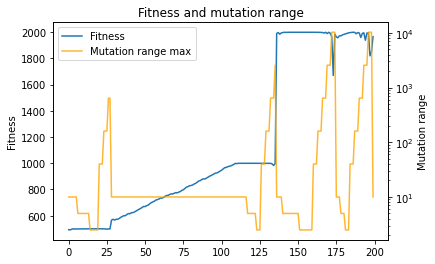

In [10]:
mutation_range_max = []

for log in memory_logger.log:
    mutation_range_max.append(log["generator"][layers[1].name+"/mutation_range_max"])

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()

h1 = ax.plot(hist.max(axis=1), label="Fitness")[0]
ax.set_ylabel("Fitness")

h2 = ax2.plot(mutation_range_max, color="orange", label="Mutation range max", alpha=0.8)[0]
ax2.set_yscale("log")
ax2.set_ylabel("Mutation range")

plt.title("Fitness and mutation range")
plt.xlabel("Generation")
plt.legend(handles=[h1, h2])
plt.show()

![](Example4-Figure1.jpg)

# FileLogger

# WandbLogger

Another way of saving your logs is upload it to [Weights & Biases](https://wandb.ai/site), a plataform for experiment tracking.

First, you will need to install and log in to wandb (skip if you already logged in):

In [ ]:
!pip install wandb
!wandb login

Then, we can create a WandbLogger callback and use it to log our data:

In [ ]:
from evolvepy.integrations.wandb import WandbLogger

wandb_logger = WandbLogger(name="ExampleRun", project="EvolvePy Example")

evolver = Evolver(generator, evaluator, 100, callbacks=[dyn_mut, wandb_logger])  

hist, last_population = evolver.evolve(200)

Go to the run link shown above to see the data. 